In [1]:
import os
os.environ['HEASOFTPYDIR']= os.path.split(os.getcwd())[0]

import sys
sys.path.insert(0,os.environ['HEASOFTPYDIR'])
sys.path


from matplotlib.pyplot import *
import glob

import heasoftpy as hsp
import xspec

from astropy.table import Table
from astropy.time import Time
from astropy.io import fits
import astropy.units as u

# Enter your SciServer username in the cell below

In [8]:
username = 'mfacorcoran'

Setting nicerdatadir to /home/idies/workspace/Temporary/mfacorcoran/scratch


# Set up the NICER obsid directory

We'll copy a NICER observation directory for OBSID 412010107 to our ``Temporary`` directory

The OBSID directory   contains the ``xti``, ``auxil`` and ``hk`` directories containing the standard archived data for the observation

We'll put the output from nicerl2 in an ``output`` directory separate from the input directory

In [9]:
nicerdatadir = f'/home/idies/workspace/Temporary/{username}/scratch'
print(f'Setting nicerdatadir to {nicerdatadir}')

Setting nicerdatadir to /home/idies/workspace/Temporary/mfacorcoran/scratch


In [10]:
obsid = '4142010107'

## Find the NICER data directory for OBSID  

In [11]:
nicerobs = !ls  -d /home/idies/workspace/headata/FTP/nicer/data/obs/*/{obsid}
nicerobs = nicerobs[0]
nicerobs

'/home/idies/workspace/headata/FTP/nicer/data/obs/2021_11/4142010107'

In [12]:
cmd = f'cp -r {nicerobs} {nicerdatadir}'
stat = os.system(cmd)

In [13]:
cwd = os.getcwd()
os.chdir(nicerdatadir)

In [15]:
nicerdatadir


'/home/idies/workspace/Temporary/mfacorcoran/scratch'

In [16]:
nicerobsID = obsid
obsdir = os.path.join(nicerdatadir, nicerobsID)

# place cleaned output in a separate directory
outdir =  os.path.join(os.environ['HOME'],nicerdatadir,'nicerl2_output/'+nicerobsID+'_out')
# if outdir doesn't exist, create it
if not os.path.exists(outdir):
    os.makedirs(outdir)
    print(f'Created {outdir}')
# copy the mkf file from the input directory to the outdir

Created /home/idies/workspace/Temporary/mfacorcoran/scratch/nicerl2_output/4142010107_out


In [17]:
mkf = os.path.join(obsdir,'auxil',f'ni{nicerobsID}.mkf')
if os.path.exists(mkf):
    # see if mkf is gzipped    
    cmd = f'cp {mkf} {outdir}/.'
    stat=os.system(cmd)
    mkf = os.path.join(outdir, os.path.split(mkf)[1])
    print(f'Setting mkf file to {mkf}')
elif os.path.exists(mkf+'.gz'):
    #try to copy gzipped mkf     
    cmd = f'cp {mkf}.gz {outdir}/.'
    print(cmd)
    os.system(cmd)
    mkf = os.path.join(outdir, os.path.split(mkf)[1])
    print(f'Setting mkf file to {mkf}')
    #cmd = f'gunzip -f {mkf}.gz'
    #print(cmd)
    #stat=os.system(cmd)
cmd = f'chmod u+w {mkf}*'
print(cmd)
stat = os.system(cmd)

cp /home/idies/workspace/Temporary/mfacorcoran/scratch/4142010107/auxil/ni4142010107.mkf.gz /home/idies/workspace/Temporary/mfacorcoran/scratch/nicerl2_output/4142010107_out/.
Setting mkf file to /home/idies/workspace/Temporary/mfacorcoran/scratch/nicerl2_output/4142010107_out/ni4142010107.mkf
chmod u+w /home/idies/workspace/Temporary/mfacorcoran/scratch/nicerl2_output/4142010107_out/ni4142010107.mkf*


# Create the nicerl2 task

In [18]:
tstart = Time.now()
print(f'Start at: {tstart.iso[:19]}')
nicerl2 = hsp.HSPTask('nicerl2')

nicerl2.clobber="yes"
#nicerl2.cldir=outdir
#nicerl2.mkffile=mkf
# add the KP values to the mkf file during nicerl2 processing
nicerl2.geomag_path="https://heasarc.gsfc.nasa.gov/FTP/caldb/data/gen/pcf/geomag/"
nicerl2.geomag_columns="kp_noaa.fits(KP)"

resl2 = nicerl2(indir=nicerobsID, noprompt=True, cldir=outdir, mkfile=mkf)

tend = Time.now()
print(f'End at: {tend.iso[:19]}')
print(f'nicerl2 took: {(tend.mjd-tstart.mjd)*86400} seconds')

if resl2.returncode != 0:
    print('\n')
    for o in resl2.output[:]:
        print(o)


Start at: 2022-06-07 18:53:11
End at: 2022-06-07 18:55:01
nicerl2 took: 110.28139174450189 seconds


# Extract products from cleaned events file

In [20]:
os.chdir(outdir)

clevt = f'ni{nicerobsID}_0mpu7_cl.evt'
phafile = f'ni{nicerobsID}_0mpu7_cl.pha'
lcfile = f'ni{nicerobsID}_0mpu7_cl.lc'
res = hsp.extractor(filename=clevt, phafile=phafile, clobber='yes', binlc=10.0,fitsbinlc=lcfile, 
                    eventsout='NONE', imgfile='NONE', regionfile='NONE', timefile='NONE', tcol='TIME',
                    ecol='PI', xcolf='RAWX', xcolh='RAWX',ycolf='RAWY', ycolh='RAWY',
                    stokes='NONE')

In [21]:
print(res.stdout)

extractor v6.07     8 Apr 2022
 Getting FITS WCS Keywords
 Doing file: ni4142010107_0mpu7_cl.evt
100% completed
          Total      Good    Bad: Time     Phase     Grade       Cut
         727352    727352            0         0         0         0
    Grand Total      Good    Bad: Time     Phase     Grade       Cut
         727352    727352            0         0         0         0
   in  1055.0     seconds
 Fits light curve has  7.2735E+05 counts for   689.4     counts/sec
 Thresholding removed significant counts
 Try exposure=0.0 on the extract command in xselect
 or lcthresh=0.0 if running extractor stand-alone
 Thresholding removed more than half the bins
 Try exposure=0.0 on the extract command in xselect
 or lcthresh=0.0 if running extractor stand-alone
 Spectrum         has   727352 counts for   689.4     counts/sec
Keyword TSTART has two values: 247803405.997195 and 247803493
Keyword TSTOP has two values: 247878072.68997 and 247878062
 ... written the PHA data Extension



# Analyzing NICER spectra

We'll just use the on-axis RMF and ARF files

In [22]:
# get the on-axis rmf
res = hsp.quzcif(mission='nicer', instrument='xti',detector='-',
             filter='-', date='-', time='-',expr='-',codename='MATRIX')
rmf = [x.split()[0] for x in res.output if 'nixtiref'  in x][0]

# get the on-axis arf
res = hsp.quzcif(mission='nicer', instrument='xti',detector='-',
             filter='-', date='-', time='-',expr='-',codename='SPECRESP')
arf = [x.split()[0] for x in res.output if 'nixtiaveonaxis'  in x][0]


In [23]:
!ls /home/idies/workspace/Storage/mfacorcoran/persistent/nicerl2_output/4142010107_out/

ni4142010107.mkf	    ni4142010107_0mpu5_ufa.evt
ni4142010107.mkf.gz	    ni4142010107_0mpu6_ufa.evt
ni4142010107_0mpu0_ufa.evt  ni4142010107_0mpu7_cl.evt
ni4142010107_0mpu1_ufa.evt  ni4142010107_0mpu7_cl.lc
ni4142010107_0mpu2_ufa.evt  ni4142010107_0mpu7_cl.pha
ni4142010107_0mpu3_ufa.evt  ni4142010107_0mpu7_ufa.evt
ni4142010107_0mpu4_ufa.evt


In [24]:
xspec.AllData.clear()
spec = xspec.Spectrum(phafile)
spec.response = rmf
spec.response.arf = arf
spec.ignore('0.0-0.3, 10.0-**')


1 spectrum  in use
 
Spectral Data File: ni4142010107_0mpu7_cl.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.894e+02 +/- 8.084e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1501
  Telescope: NICER Instrument: XTI  Channel Type: PI
  Exposure Time: 1055 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.
Arf successfully loaded.
    30 channels (1-30) ignored in spectrum #     1
   502 channels (1000-1501) ignored in spectrum #     1



In [26]:
# assume a simple model

model = xspec.Model('wabs*bknpow')
xspec.Fit.perform()


Model wabs<1>*bknpower<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   wabs       nH         10^22    1.00000      +/-  0.0          
   2    2   bknpower   PhoIndx1            1.00000      +/-  0.0          
   3    2   bknpower   BreakE     keV      5.00000      +/-  0.0          
   4    2   bknpower   PhoIndx2            2.00000      +/-  0.0          
   5    2   bknpower   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              5.535691e+06     using 969 bins.

Test statistic : Chi-Squared              5.535691e+06     using 969 bins.
 Null hypothesis probability of 0.000000e+00 with 964 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl          1:nH    2:PhoIndx1      3:BreakE    4:PhoIndx2        5:norm
225828       42512.5       0   

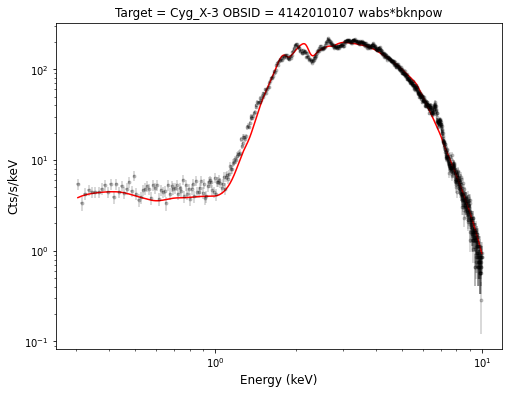

In [27]:
%matplotlib inline
xspec.Plot.device='/null'
xspec.Plot.xAxis='keV'
xspec.Plot('lda')
cr=xspec.Plot.y()
crerr = xspec.Plot.yErr()
en = xspec.Plot.x()
enwid = xspec.Plot.xErr()
mop = xspec.Plot.model()
target = fits.open(spec.fileName)[1].header['OBJECT']


fig = figure(figsize=[8,6])
ylabel('Cts/s/keV', fontsize=12)
xlabel('Energy (keV)', fontsize=12)
title('Target = '+target+' OBSID = '+nicerobsID+' wabs*bknpow', fontsize=12)
yscale('log')
xscale('log')
errorbar(en, cr, xerr=enwid, yerr=crerr, fmt='k.', alpha=0.2)
plot(en, mop,'r-')

In [28]:
target = fits.open(spec.fileName)[1].header['OBJECT']
target

'Cyg_X-3'

# Plot the lightcurve

We'll plot the lightcurve for each GTI individually

In [32]:
lctab = Table.read(lcfile,hdu='RATE')
gtitab = Table.read(lcfile, hdu='GTI')
gtitab['START']=gtitab['START']-lctab.meta['TSTART']
gtitab['STOP']=gtitab['STOP']-lctab.meta['TSTART']

In [33]:
# remove rows with no values from gtitab

row2remove=[]
for j in enumerate(gtitab):
    i=j[0]
    tsel = (lctab['TIME']>=gtitab[i]['START']) & (lctab['TIME']<=gtitab[i]['STOP'])
    if len(lctab[tsel]) < 1:
        row2remove.append(i)
gtitab.remove_rows(row2remove)
numgtis = len(gtitab)

0 39
1 3
2 59


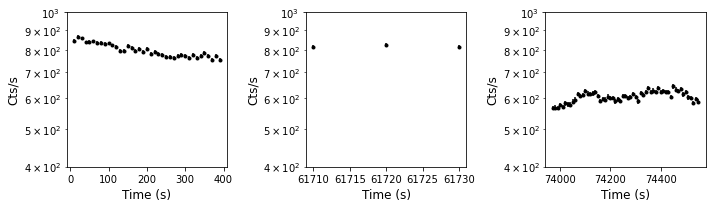

In [34]:
%matplotlib inline
fig, ax =subplots(1,numgtis,figsize=[10,3])
for i in range(numgtis):
    tsel = (lctab['TIME']>gtitab[i]['START']) & (lctab['TIME']<gtitab[i]['STOP'])
    t = lctab[tsel]['TIME']
    print(i, len(lctab[tsel]))
    r = lctab[tsel]['RATE']
    re = lctab[tsel]['ERROR']
    ax[i].set_ylabel('Cts/s', fontsize=12)
    ax[i].set_xlabel('Time (s)', fontsize=12)
    ax[i].set_yscale('log')
    ax[i].set_ylim(400, 1000)
    ax[i].errorbar(t, r,yerr=re, fmt='k.')
    tight_layout()